In [104]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
from salishsea_tools import geo_tools, geo_tools, tidetools
import functools
from IPython.display import clear_output
import datetime


%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [2]:
# Function used to get chlorophyll data from text files produced in 2003, 2004, 2005 cruises
def extract_data(file_path):
    file_description = []
    default_cols = ["STATION", "DATE", "TIME", "LAT", "LON"]
    time_loc_data = 5*["NaN"]
    data_list = []
    with open(file_path) as f:
            indata = False
            for line in f:
                if not indata:
                    if line.startswith("%"):
                        file_description.append(line)
                    elif line.startswith("*"):
                        split_line = line.split()
                        columns = split_line[1:len(split_line)]
                        num_cols = len(columns)
                        indata = True
                else:
                    split_line = line.split()
                    if not line.startswith("S") and not line.startswith("T") and not line.startswith("F") and not line.startswith("P") and len(split_line) == num_cols:
                        data_list.append(time_loc_data + split_line)
                    elif len(split_line) > 0:
                        try:
                            station = split_line[0]
                        except:
                            station = "NaN"
                        try:
                            date = split_line[2] + " " + split_line[3] + " " + split_line[4]
                            date = pd.to_datetime(date, infer_datetime_format=True)
                        except:
                            date = pd.to_datetime("NaN", infer_datetime_format=True, errors = "coerce")
                        try:
                            time = split_line[5]
                        except:
                            time = "NaN"
                        try:
                            lat = split_line[6] + " " + split_line[7]
                            lon = split_line[9] + " " + split_line[10]
                        except:
                            lat, lon = "NaN", "NaN"
                        time_loc_data = [station,date,time,lat,lon]
            
    return(pd.DataFrame(data_list, columns = default_cols + columns))

In [3]:
# Iterate through top level chlorophyll data directory, grabbing data from applicable files

basedir = "/ocean/shared/SoG/btl/"
chl_dict = dict()

for subdir in os.listdir(basedir):
    if os.path.isdir(basedir + '/' + subdir):
        for file in os.listdir(basedir + '/' + subdir):
            if file.startswith("bottle") and file.endswith(".txt"):
                chl_dict[subdir] = extract_data(basedir + "/" + subdir + "/" + file)
                break

In [4]:
# Convert from Sexagesimal lat or lon string to decimal lat or lon float
def strToLatLon(s):
    try:
        split_str = s.split()
        return(float(split_str[0]) + float(split_str[1])/60)
    except:
        return(np.nan)

In [5]:
# Convert chlorophyll dataframe column types

all_chl = pd.concat(chl_dict, join = "inner")
all_chl.reset_index(inplace = True)

all_chl["DEPTH"] = pd.to_numeric(all_chl["depth"], errors='coerce')
all_chl["chl002"] = pd.to_numeric(all_chl["chl002"], errors='coerce')
all_chl["chl020"] = pd.to_numeric(all_chl["chl020"], errors='coerce')
all_chl["chl200"] = pd.to_numeric(all_chl["chl200"], errors='coerce')

all_chl["DECIMAL_LAT"] = (all_chl["LAT"].apply(strToLatLon))
all_chl["DECIMAL_LON"] = (all_chl["LON"].apply(strToLatLon))
all_chl["DECIMAL_LON"] = -all_chl["DECIMAL_LON"] # needs to be negative to match grid lon/lats
all_chl["STATION_LAT"] =  all_chl.groupby("STATION")["DECIMAL_LAT"].transform(np.median)
all_chl["STATION_LON"] =  all_chl.groupby("STATION")["DECIMAL_LON"].transform(np.median)

In [6]:
# Create smaller data frame with location of stations
station_lon_lat = all_chl[["STATION", "STATION_LON", "STATION_LAT"]].drop_duplicates()
station_lon_lat.columns = ["STATION", "LON", "LAT"]

In [8]:
# Add corresponding model points to station data frame
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid_B)

def closest_model_point_wrapper(lon, lat):
    try:
        model_point = geo_tools.find_closest_model_point(lon, lat, model_lons = X, model_lats = Y, grid = 'NEMO', land_mask = bathy.mask)
        return(model_point)
    except:
        print("ERROR" + str(lon) + " " + str(lat))
        return(np.nan)
    
station_lon_lat["MODEL_POINT"] = station_lon_lat.apply(lambda row: closest_model_point_wrapper(row[1], row[2]) , axis = 1)
station_lon_lat["MODEL_J"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[0])
station_lon_lat["MODEL_I"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[1])


In [9]:
# Grab plankton data from excel file
df_list = []
for i in range(1,4):
    df = pd.read_excel('/ocean/shared/SoG/PHYTO/Profiles_by_station.xls',i)
    top_index = pd.Index(df["Vol"]).get_loc("Species")
    bottom_index = pd.Index(df["Vol"]).get_loc("Carbon (ng/l)")
    df = pd.concat([df.iloc[:top_index], df.iloc[(bottom_index + 1):]])
    df = df.transpose()
    df.columns = df.iloc[0]
    df.drop(df.index[0], inplace=True)
    df.reset_index(inplace = True)
    df_list.append(df)

In [10]:
# convert plankton dataframe column data types
all_plank = pd.concat(df_list,  axis=0, ignore_index=True)
all_plank["STATION"] = "S" + all_plank["Site"].astype(str).str.strip()
all_plank["DATE"] = pd.to_datetime(all_plank["Date"], format='%Y-%m-%d', errors = "coerce")
all_plank["DEPTH"] = pd.to_numeric(all_plank["Depth (m)"], errors = "coerce")

In [108]:
# Choose which values to add to nowcast dataframe

tracers = ["PHY2"]

plot_months = ["apr","may"]

plot_hours = np.array([0, 12, 18])
result_hours = pd.DatetimeIndex(grid_t.time_centered.values).hour
time_indices = np.where([(x in plot_hours) for x in result_hours])

max_depth = 20
result_depths = grid_t.deptht.values
depth_indices = np.where(result_depths < max_depth)[0]

model_points = station_lon_lat["MODEL_POINT"]
model_js = [x[0] for x in model_points] 
model_is = [x[1] for x in model_points] 

stations = station_lon_lat["STATION"]

J, T, Z = np.meshgrid(model_js,time_indices,depth_indices, indexing = 'ij')
I, T, Z = np.meshgrid(model_is,time_indices,depth_indices, indexing = 'ij')

In [110]:
# Iterate through nowcast green results, grabbing certain tracers, locations, and dates/times
# Create pandas dataframe and save result

nowcast_dir = "/results/SalishSea/nowcast-green/" #"/data/jpetrie/MEOPAR/SalishSea/results/nowcast_results/"

month_num = {"jan": "01","feb": "02", "mar": "03", "apr": "04", "may": "05", "jun": "06", "jul": "07", "aug": "08", "sep": "09", "oct": "10", "nov": "11", "dec": "12" }

dataframe_list = []

num_files = 0
start_time = datetime.datetime.now()
for subdir in os.listdir(nowcast_dir):
    if os.path.isdir(nowcast_dir + '/' + subdir) and re.match("[0-9]{2}[a-z]{3}[0-9]{2}", subdir):
        month_str = subdir[2:5]
        date_str = "20" + subdir[5:7] + month_num[month_str] + subdir[0:2]
        tracer_file = "SalishSea_1h_" + date_str + "_" + date_str + "_ptrc_T.nc"
        tracer_path = nowcast_dir + "/" + subdir + "/" + tracer_file
        if os.path.isfile(tracer_path) and month_str in plot_months:
            grid_t = xr.open_dataset(tracer_path)
            tracer_dataframes = []
            for t in tracers:
                station_slice = grid_t[t].values[T,Z,J,I]
                slice_xarray = xr.DataArray(station_slice,
                                 [stations,result_hours[time_indices], result_depths[depth_indices]],
                                 ["STATION", "HOUR", "DEPTH"], 
                                 t)
                slice_dataframe = slice_xarray.to_dataframe()
                slice_dataframe.reset_index(inplace = True)
                tracer_dataframes.append(slice_dataframe)
            merged_tracers = functools.reduce(lambda left,right: pd.merge(left,right,on=["STATION", "HOUR", "DEPTH"]), tracer_dataframes)
            merged_tracers["DATE"] = date_str
            merged_tracers["MONTH"] = int(month_num[month_str])
            dataframe_list.append(merged_tracers)
            
            num_files = num_files + 1
            run_time = datetime.datetime.now() - start_time
            clear_output()
            print("Files loaded:" + str(num_files))
            print("Date of most recent nowcast load: " + date_str)
            print("Time loading: ")
            print(run_time)
            print("\n\n\n")
            print(merged_tracers)
            
nowcast_df = pd.concat(dataframe_list)    
t = datetime.datetime.now()
time_string = str(t.year) +"_"+ str(t.month) +"_"+ str(t.day) +"_"+ str(t.hour) +"_"+ str(t.minute)
nowcast_df.to_pickle("/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/"+time_string ".pkl") 

Files loaded:61
Date of most recent nowcast load: 20160503
Time loading: 
0:04:50.030888




     STATION  HOUR      DEPTH      PHY2      DATE  MONTH
0       S2-3     0   0.500000  2.125582  20160503      5
1       S2-3     0   1.500003  2.080158  20160503      5
2       S2-3     0   2.500011  1.729216  20160503      5
3       S2-3     0   3.500031  1.743587  20160503      5
4       S2-3     0   4.500071  1.434275  20160503      5
5       S2-3     0   5.500151  0.939941  20160503      5
6       S2-3     0   6.500310  1.400602  20160503      5
7       S2-3     0   7.500623  1.746323  20160503      5
8       S2-3     0   8.501236  2.389727  20160503      5
9       S2-3     0   9.502433  2.551562  20160503      5
10      S2-3     0  10.504766  2.669873  20160503      5
11      S2-3     0  11.509312  2.797817  20160503      5
12      S2-3     0  12.518167  2.967327  20160503      5
13      S2-3     0  13.535412  3.260831  20160503      5
14      S2-3     0  14.568982  3.367944  20160503   

In [135]:
nowcast_df

STATION  HOUR      DEPTH      PHY2      DATE  MONTH
0       S2-3     0   0.500000  2.730984  20160518      5
1       S2-3     0   1.500003  2.978634  20160518      5
2       S2-3     0   2.500011  2.884226  20160518      5
3       S2-3     0   3.500031  3.442029  20160518      5
4       S2-3     0   4.500071  3.755846  20160518      5
5       S2-3     0   5.500151  3.536387  20160518      5
6       S2-3     0   6.500310  3.341271  20160518      5
7       S2-3     0   7.500623  3.978837  20160518      5
8       S2-3     0   8.501236  5.608349  20160518      5
9       S2-3     0   9.502433  6.059659  20160518      5
10      S2-3     0  10.504766  4.588202  20160518      5
11      S2-3     0  11.509312  3.358920  20160518      5
12      S2-3     0  12.518167  2.638591  20160518      5
13      S2-3     0  13.535412  2.204628  20160518      5
14      S2-3     0  14.568982  1.826163  20160518      5
15      S2-3     0  15.634288  1.657499  20160518      5
16      S2-3     0  16.761173  1.417523  20160518      5
17      S2-3     0  18.007135  1.310623  20160518      5
18      S2-3     0  19.481785  1.165707  20160518      5
19      S2-3    12   0.500000  1.988361  20160518      5
20      S2-3    12   1.500003  2.045145  20160518      5
21      S2-3    12   2.500011  2.459929  20160518      5
22      S2-3    12   3.500031  2.613025  20160518      5
23      S2-3    12   4.500071  2.661656  20160518      5
24      S2-3    12   5.500151  2.753057  20160518      5
25      S2-3    12   6.500310  2.793836  20160518      5
26      S2-3    12   7.500623  3.021246  20160518      5
27      S2-3    12   8.501236  3.363177  20160518      5
28      S2-3    12   9.502433  3.805924  20160518      5
29      S2-3    12  10.504766  4.346595  20160518      5
...      ...   ...        ...       ...       ...    ...
1851    S6-2    12   8.501236  0.956252  20160503      5
1852    S6-2    12   9.502433  1.104801  20160503      5
1853    S6-2    12  10.504766  1.320643  20160503      5
1854    S6-2    12  11.509312  1.730911  20160503      5
1855    S6-2    12  12.518167  2.696275  20160503      5
1856    S6-2    12  13.535412  3.887129  20160503      5
1857    S6-2    12  14.568982  4.780806  20160503      5
1858    S6-2    12  15.634288  5.057674  20160503      5
1859    S6-2    12  16.761173  4.847612  20160503      5
1860    S6-2    12  18.007135  4.190577  20160503      5
1861    S6-2    12  19.481785  3.128766  20160503      5
1862    S6-2    18   0.500000  0.598412  20160503      5
1863    S6-2    18   1.500003  0.760846  20160503      5
1864    S6-2    18   2.500011  0.801621  20160503      5
1865    S6-2    18   3.500031  0.787006  20160503      5
1866    S6-2    18   4.500071  0.733540  20160503      5
1867    S6-2    18   5.500151  0.823397  20160503      5
1868    S6-2    18   6.500310  1.047997  20160503      5
1869    S6-2    18   7.500623  1.385617  20160503      5
1870    S6-2    18   8.501236  1.499932  20160503      5
1871    S6-2    18   9.502433  1.714590  20160503      5
1872    S6-2    18  10.504766  2.506615  20160503      5
1873    S6-2    18  11.509312  3.352606  20160503      5
1874    S6-2    18  12.518167  4.010559  20160503      5
1875    S6-2    18  13.535412  4.113744  20160503      5
1876    S6-2    18  14.568982  4.215158  20160503      5
1877    S6-2    18  15.634288  3.999062  20160503      5
1878    S6-2    18  16.761173  3.663707  20160503      5
1879    S6-2    18  18.007135  3.174665  20160503      5
1880    S6-2    18  19.481785  2.630758  20160503      5

[114741 rows x 6 columns]

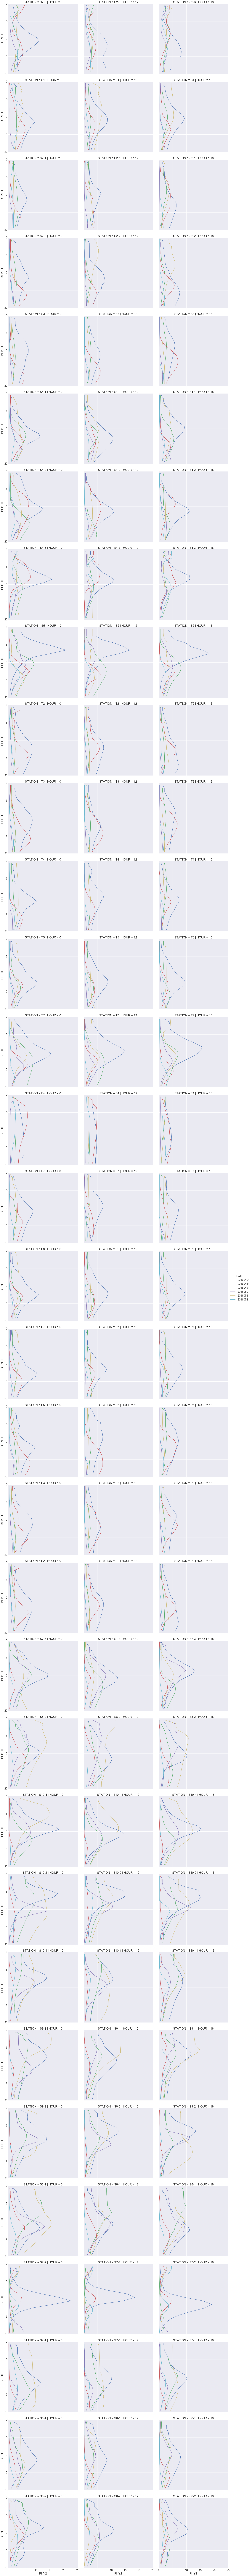

In [141]:
sns.set(font_scale = 2)
fg = sns.FacetGrid(data = nowcast_df[(pd.to_numeric(nowcast_df["DATE"])%100).isin([1,11,21])], hue = "DATE",col = "HOUR", row = "STATION", size =8)
fg.map(plt.plot, "PHY2", "DEPTH").add_legend()
plt.gca().invert_yaxis()

In [ ]:
# Compare nowcast results with chlorophyll and plankton data